# Hiding future words with causal attention
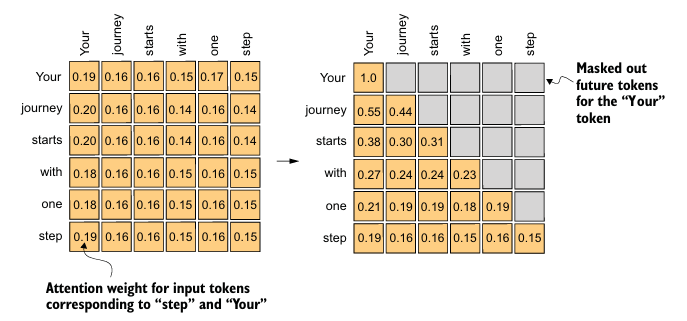

## Applying a causal attention mask
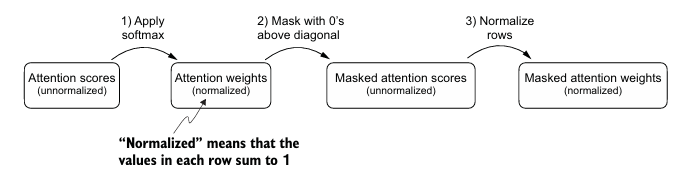

In [31]:
import torch
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        # trainable weights
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T 
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1 # normalization 
        )

        context_vec = attn_weights @ values
        return context_vec


inputs = torch.tensor(
  [[0.43, 0.15, 0.89], 
   [0.55, 0.87, 0.66], 
   [0.57, 0.85, 0.64], 
   [0.22, 0.58, 0.33], 
   [0.77, 0.25, 0.10], 
   [0.05, 0.80, 0.55]] 
)

d_in = inputs.shape[-1]
d_out = d_in

sa = SelfAttention_v1(d_in, d_out)
queries = sa.W_query(inputs)
keys = sa.W_key(inputs)
values = sa.W_value(inputs)

atten_scores = queries @ keys.T

# normalization
atten_weights = torch.softmax(
    atten_scores / keys.shape[-1]**0.5, dim=-1
)
print(atten_weights)

tensor([[0.1644, 0.1668, 0.1672, 0.1659, 0.1727, 0.1629],
        [0.1530, 0.1664, 0.1666, 0.1719, 0.1730, 0.1691],
        [0.1535, 0.1664, 0.1667, 0.1716, 0.1729, 0.1689],
        [0.1568, 0.1664, 0.1665, 0.1709, 0.1699, 0.1696],
        [0.1673, 0.1672, 0.1673, 0.1651, 0.1694, 0.1637],
        [0.1512, 0.1660, 0.1661, 0.1737, 0.1711, 0.1720]],
       grad_fn=<SoftmaxBackward0>)


In [32]:
atten_weights.shape

torch.Size([6, 6])

In [33]:
context_length = atten_weights.shape[-1]
mask_simple = torch.tril(torch.ones((context_length, context_length)))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [34]:
masked_atten_weights = atten_weights * mask_simple
print(masked_atten_weights)

tensor([[0.1644, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1530, 0.1664, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1535, 0.1664, 0.1667, 0.0000, 0.0000, 0.0000],
        [0.1568, 0.1664, 0.1665, 0.1709, 0.0000, 0.0000],
        [0.1673, 0.1672, 0.1673, 0.1651, 0.1694, 0.0000],
        [0.1512, 0.1660, 0.1661, 0.1737, 0.1711, 0.1720]],
       grad_fn=<MulBackward0>)


In [35]:
# renormalization after masking
row_sums = masked_atten_weights.sum(dim=-1, keepdim=True)
renormalized_atten_weights = masked_atten_weights / row_sums
print(renormalized_atten_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4790, 0.5210, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3155, 0.3420, 0.3425, 0.0000, 0.0000, 0.0000],
        [0.2373, 0.2519, 0.2521, 0.2587, 0.0000, 0.0000],
        [0.2000, 0.1999, 0.2001, 0.1974, 0.2025, 0.0000],
        [0.1512, 0.1660, 0.1661, 0.1737, 0.1711, 0.1720]],
       grad_fn=<DivBackward0>)


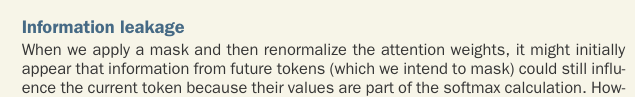

Let's take a mathematical property of the softmax function and implement the computation of the masked attention weights more efficiently in few steps.

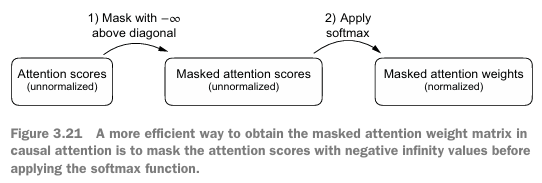

In [36]:
mask = torch.triu(torch.ones((context_length, context_length)), diagonal=1)
masked = atten_scores.masked_fill(mask.bool(), float('-inf'))
print(masked)

tensor([[-0.0179,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.2201, -0.0747,    -inf,    -inf,    -inf,    -inf],
        [-0.2100, -0.0702, -0.0677,    -inf,    -inf,    -inf],
        [-0.1645, -0.0611, -0.0601, -0.0152,    -inf,    -inf],
        [ 0.0321,  0.0314,  0.0331,  0.0099,  0.0538,    -inf],
        [-0.2686, -0.1068, -0.1056, -0.0277, -0.0545, -0.0450]],
       grad_fn=<MaskedFillBackward0>)


In [37]:
atten_weights = torch.softmax(
    masked / keys.shape[-1]**0.5, dim=-1) 

print(atten_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4790, 0.5210, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3155, 0.3420, 0.3425, 0.0000, 0.0000, 0.0000],
        [0.2373, 0.2519, 0.2521, 0.2587, 0.0000, 0.0000],
        [0.2000, 0.1999, 0.2001, 0.1974, 0.2025, 0.0000],
        [0.1512, 0.1660, 0.1661, 0.1737, 0.1711, 0.1720]],
       grad_fn=<SoftmaxBackward0>)


## Masking additional attention weights with dropout
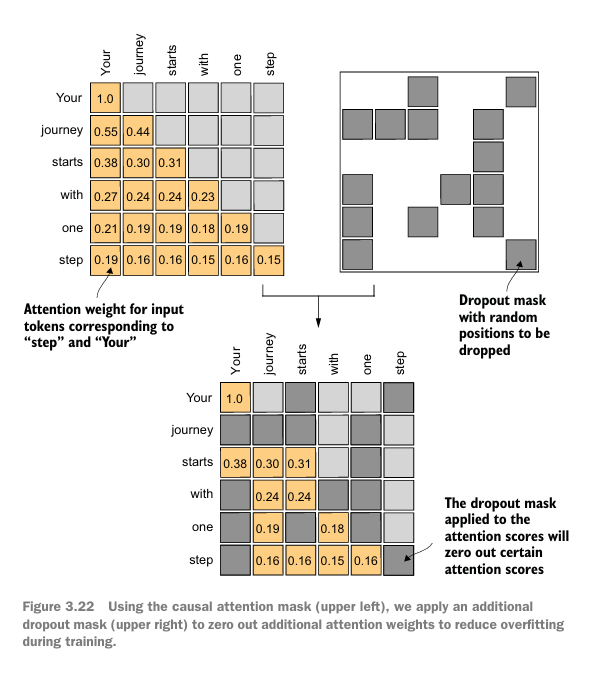

In [38]:
dropout = nn.Dropout(p=0.5) # we use a dropout rate of 50%, (when we train the GPT model, we use 10-20%)

dpt_atten_weights = dropout(atten_weights)
print(dpt_atten_weights)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9581, 1.0419, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6840, 0.6850, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5038, 0.5041, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3998, 0.4002, 0.3949, 0.4050, 0.0000],
        [0.3023, 0.0000, 0.0000, 0.0000, 0.0000, 0.3440]],
       grad_fn=<MulBackward0>)


In [39]:
context_vectors = dpt_atten_weights @ values
print(context_vectors)

tensor([[-1.4076,  0.7653,  1.3642],
        [-1.6824,  0.5408,  1.4497],
        [-1.3136,  0.2303,  1.0435],
        [-0.9672,  0.1696,  0.7683],
        [-1.1415,  0.2143,  0.9541],
        [-0.4645,  0.1248,  0.3609]], grad_fn=<MmBackward0>)


## Implementing a compact causal self-attention class

In [ ]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) 
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) 

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b 
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) 

        context_vec = attn_weights @ values
        return context_vec